In [131]:
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

In [132]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
dataset["remarks"] = "No DLC available"
datasets["ROAD"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
# dataset["remarks"] = "-"
# datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "ID", "DLC", "t"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dt,dt_ID,dt_ID_d0,dt_ID_d1,dt_ID_d2,dt_ID_d3,dt_ID_d4,dt_ID_d5,dt_ID_d6,dt_ID_d7,name,dataset,type,Label
0,4.073523e-04,0.009999,0.012513,0.062368,0.039715,0.009999,0.009999,0.022790,1.849937,0.019992,correlated_signal_attack_1,ROAD,none,0
1,1.019955e-03,0.009999,0.009999,0.098977,0.071700,0.009999,0.016000,0.024942,0.429991,0.009999,correlated_signal_attack_1,ROAD,none,0
2,1.072884e-06,0.019998,0.019998,0.019998,0.019998,0.019998,0.019998,0.019998,0.019998,0.019998,correlated_signal_attack_1,ROAD,none,0
3,2.026558e-06,0.009999,0.009999,0.012457,0.116082,0.024390,0.033220,0.010202,0.052899,0.009999,correlated_signal_attack_1,ROAD,none,0
4,9.536743e-07,0.009998,0.159980,0.015266,0.009998,0.022314,1.919316,0.022494,1.412325,0.009998,correlated_signal_attack_1,ROAD,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266459,1.192093e-06,0.050870,0.050870,0.050870,0.050870,0.050870,0.050870,0.050870,0.050870,0.050870,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266460,9.977818e-04,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,0.019898,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266461,2.145767e-06,0.010723,0.010723,0.010723,0.010723,0.010723,0.010723,0.010723,0.010723,0.010723,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266462,9.536743e-07,0.025351,0.025351,0.025351,0.025351,0.025351,2.498928,10.247014,0.074863,0.025351,reverse_light_on_attack_3_masquerade,ROAD,none,0


In [133]:
# # Compute the correlation matrix
# corr = df.drop(columns=["dataset", "type", "name", "ID", "DLC", "t"], errors="ignore").corr()

# # Drop first row and last column that don't provide information
# corr.drop(index=corr.index[0], inplace=True)
# corr.drop(columns=corr.columns[-1], inplace=True)

# # Generate a mask for the upper triangle but not the diagonal
# mask = np.triu(np.ones_like(corr, dtype=bool))
# np.fill_diagonal(mask, False)

# # Draw the correlation heatmap with the mask
# def tostr(num):
#     if isinstance(num, str): return num
#     if num < 0: return str(num)[:5]
#     return str(num)[:4]
# def remove_nocorr(corr):
#     annot = corr.copy()
#     annot.where(np.abs(annot) > 0.1, " ", inplace=True)
#     annot = annot.applymap(tostr)
#     return annot
# annots = remove_nocorr(corr)

# plt.figure(dpi=200)
# sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=annots, annot_kws={"fontsize": 5}, fmt="s", square=True)
# plt.title("ROAD Dataset Correlation Matrix (Pearson)")
# plt.show()

In [134]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [135]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "Label")] = StandardScaler(copy=True).fit_transform(
    df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "Label")]
)

display(df)

,dt,dt_ID,dt_ID_d0,dt_ID_d1,dt_ID_d2,dt_ID_d3,dt_ID_d4,dt_ID_d5,dt_ID_d6,dt_ID_d7,name,dataset,type,Label
0,-0.010446,-0.249418,-0.066493,-0.071148,-0.068556,-0.097720,-0.196699,-0.170409,0.588133,-0.127752,correlated_signal_attack_1,ROAD,none,0
1,0.988909,-0.249421,-0.068662,-0.043543,-0.030504,-0.097720,-0.194104,-0.169087,0.008867,-0.134086,correlated_signal_attack_1,ROAD,none,0
2,-0.673220,-0.176065,-0.060038,-0.103097,-0.092013,-0.091041,-0.192376,-0.172123,-0.158389,-0.127749,correlated_signal_attack_1,ROAD,none,0
3,-0.671664,-0.249418,-0.068662,-0.108783,0.022298,-0.088108,-0.186659,-0.178136,-0.144967,-0.134085,correlated_signal_attack_1,ROAD,none,0
4,-0.673415,-0.249423,0.060702,-0.106664,-0.103909,-0.089494,0.628777,-0.170590,0.409610,-0.134086,correlated_signal_attack_1,ROAD,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3266459,-0.673026,0.050429,-0.033409,-0.079818,-0.055284,-0.070420,-0.179028,-0.153171,-0.145795,-0.108183,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266460,0.952738,-0.176796,-0.060124,-0.103172,-0.092132,-0.091108,-0.192419,-0.172184,-0.158430,-0.127812,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266461,-0.671470,-0.244107,-0.068037,-0.110090,-0.103047,-0.097236,-0.196386,-0.177816,-0.162173,-0.133626,reverse_light_on_attack_3_masquerade,ROAD,none,0
3266462,-0.673415,-0.136790,-0.055420,-0.099060,-0.085644,-0.087466,0.879367,6.106104,-0.136007,-0.124356,reverse_light_on_attack_3_masquerade,ROAD,none,0


In [136]:
X_train = df.drop(columns="type")
y_train = df["type"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

In [137]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		22262		961175
Attack		22262		9541


In [138]:
# X_test = X_test.loc[(X_test["type"] == "fuzz") | (X_test["type"] == "none")]
# y_test = y_test.loc[X_test.index]

In [139]:
# train_index = X_train.loc[X_train["dataset"] == "ROAD"].index
# test_index = X_test.loc[X_test["dataset"] == "Survival"].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [140]:
X_train.drop(columns=["type", "dataset", "name"], inplace=True)
X_test.drop(columns=["type", "dataset", "name"], inplace=True)

In [141]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2").fit(X_train, y_train)

Training F1: 0.9987 (+/- 0.0005)
Testing F1:  0.9995(+/- 0.0000)
Kappa score:  0.9725(+/- 0.0000)


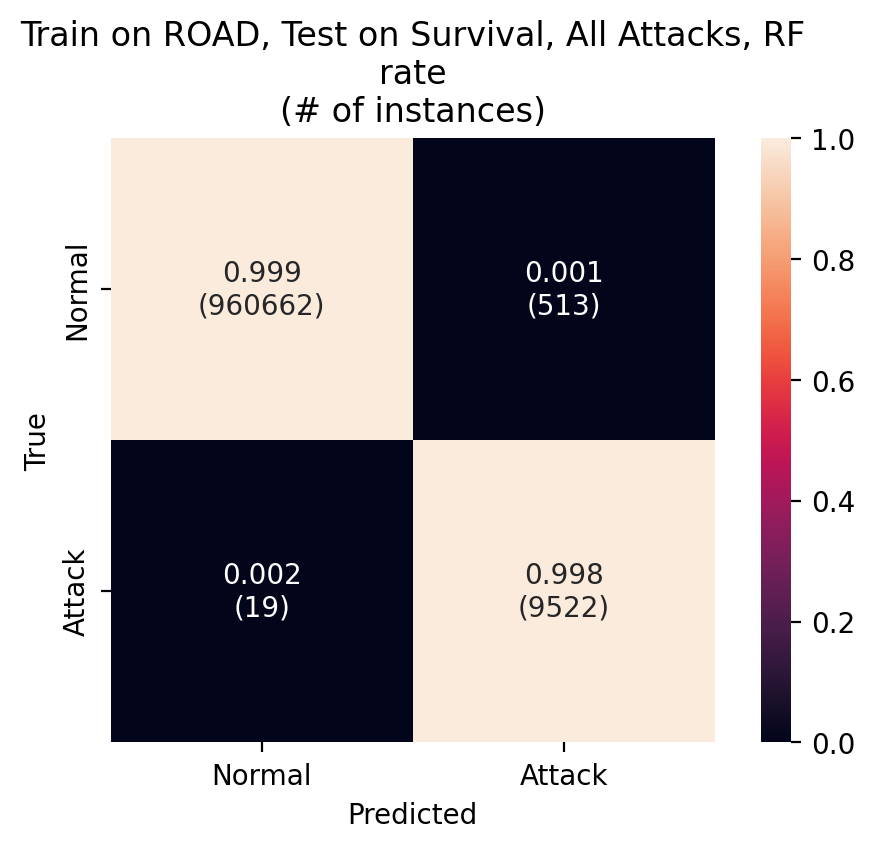

In [142]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

cm_norm = confusion_matrix(y_test, pred, normalize="true")
cm = confusion_matrix(y_test, pred)
annots = pd.DataFrame(cm_norm).applymap(lambda x: str(round(x, 3)))
annots += pd.DataFrame(cm).applymap(lambda x: f"\n({str(x)})")
plt.figure(dpi=200)
sns.heatmap(cm_norm, annot=annots, fmt="s", square=True, vmin=0, vmax=1, xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Train on ROAD, Test on Survival, All Attacks, RF\nrate\n(# of instances)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

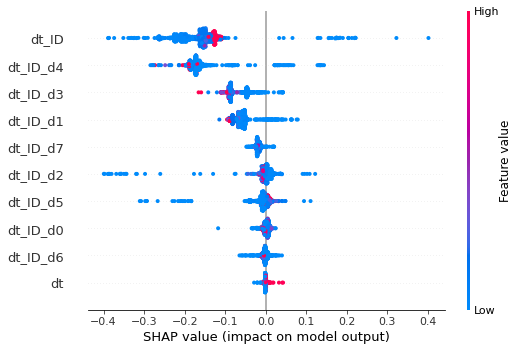

In [143]:
shap.initjs()

explainer = shap.TreeExplainer(clf)

shap_values = explainer(X_test.sample(1000, random_state=0))
shap_values = shap.Explanation(shap_values[:, :, 1], feature_names=X_test.columns)

# shap.summary_plot(shap_values)
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

# # Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# # same predictions as the original model
# assert np.abs(explainer.model.predict(X_test) - clf.predict(X_test)).max() < 1e-4

# # make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs(explainer.expected_value + explainer.shap_values(X_test).sum(1) - clf.predict(X_test)).max() < 1e-4


# shap.waterfall_plot(shap.Explanation(values=shap_values[int("which_class")][row], 
#                                          base_values=explainer.expected_value[int(which_class)], 
#                                          data=X_test.iloc[row],  # added this line
#                                          feature_names=X_test.columns.tolist()))
# shap.force_plot(explainer.expected_value[1], shap_values[1], features=X_test[:1], feature_names=X_test.columns)

# shap.plots.scatter(shap_values[:,"ones_w"])
# shap.summary_plot(shap_values[1], X_test.columns)

# plt.show()